In [ ]:
%matplotlib inline


# Second-level fMRI model: true positive proportion in clusters

This script showcases the so-called "All resolution inference" procedure, in
which the proportion of true discoveries in arbitrary clusters is estimated.
The clusters can be defined from the input image, i.e. in a circular way, as
the error control accounts for arbitrary cluster selection.

Rosenblatt JD, Finos L, Weeda WD, Solari A, Goeman JJ. All-Resolutions
Inference for brain imaging. Neuroimage. 2018 Nov 1;181:786-796. doi:
10.1016/j.neuroimage.2018.07.060


## Fetch dataset
We download a list of left vs right button press contrasts from a
localizer dataset. Note that we fetch individual t-maps that represent the
BOLD activity estimate divided by the uncertainty about this estimate.



In [1]:
from nilearn.datasets import fetch_localizer_contrasts
n_subjects = 16
data = fetch_localizer_contrasts(["left vs right button press"], n_subjects,
                                 get_tmaps=True)

from nilearn import plotting

c:\users\12sda\appdata\local\programs\python\python38-32\lib\site-packages\numpy\lib\npyio.py:2405: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


## Estimate second level model
We define the input maps and the design matrix for the second level model
and fit it.



In [4]:
import pandas as pd
second_level_input = data['cmaps']
design_matrix = pd.DataFrame([1] * len(second_level_input),
                             columns=['intercept'])
print(design_matrix)

    intercept
0           1
1           1
2           1
3           1
4           1
5           1
6           1
7           1
8           1
9           1
10          1
11          1
12          1
13          1
14          1
15          1


Model specification and fit



In [5]:
from nilearn.glm.second_level import SecondLevelModel
second_level_model = SecondLevelModel(smoothing_fwhm=8.0)
second_level_model = second_level_model.fit(second_level_input,
                                            design_matrix=design_matrix)

In [6]:
print(second_level_model)

SecondLevelModel(smoothing_fwhm=8.0)


To estimate the contrast is very simple. We can just provide the column
name of the design matrix.



In [9]:
z_map = second_level_model.compute_contrast(output_type='z_score')
print(z_map)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (53, 63, 46)
affine: 
[[  -3.    0.    0.   78.]
 [   0.    3.    0. -111.]
 [   0.    0.    3.  -51.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 53 63 46  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.  3.  3.  3.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'z_score of contrast [1.]'
aux_file        : b''
qform_code      : unknown


We threshold the second level contrast at uncorrected p < 0.001 and plot



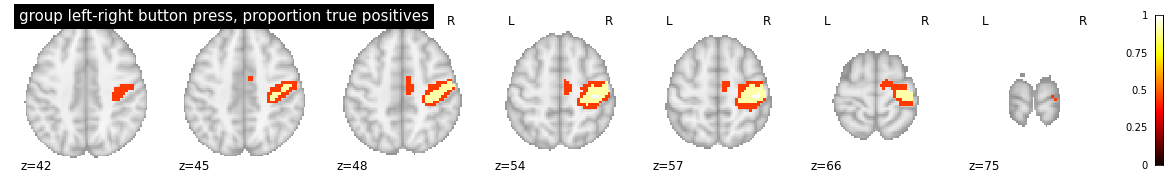

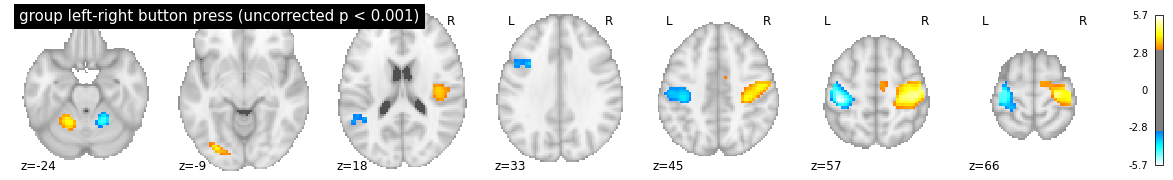

In [8]:
from scipy.stats import norm
p_val = 0.001
p001_uncorrected = norm.isf(p_val)

from nilearn.glm import cluster_level_inference
proportion_true_discoveries_img = cluster_level_inference(
    z_map, threshold=[3, 4, 5], alpha=.05)

plotting.plot_stat_map(
    proportion_true_discoveries_img, threshold=0.,
    display_mode='z', vmax=1, colorbar=True,
    title='group left-right button press, proportion true positives')

plotting.plot_stat_map(
    z_map, threshold=p001_uncorrected, colorbar=True, display_mode='z',
    title='group left-right button press (uncorrected p < 0.001)')


plotting.show()

## Comparing Simes and ARI

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sanssouci as sa
import nibabel
from nilearn.input_data import NiftiMasker
from nilearn.glm import cluster_level_inference
from nilearn.glm import fdr_threshold
from scipy.stats import norm
from nilearn.image import get_data
from scipy.ndimage import label
from nilearn.datasets import fetch_localizer_contrasts
import pandas as pd
from nilearn import plotting
from scipy import stats

import sys
sys.path.insert(1, 'C:/Users/12SDa/davenpor/davenpor/Toolboxes/pyrft/examples/nilearn_examples' )

from posthoc_fmri import *

C:\Users\12SDa\AppData\Roaming\Python\Python38\site-packages\nilearn\glm\__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
eps = 1e-7
threshold = 3  # cluster forming threshold, this time don't include all
dim = 10
alpha = 0.05
n_subjects = 16

data = fetch_localizer_contrasts(["left vs right button press"], n_subjects,
                                 get_tmaps=True)

second_level_input = data['cmaps']
nifti_masker = NiftiMasker(smoothing_fwhm=8)

fmri_input = nifti_masker.fit_transform(second_level_input)
p = fmri_input.shape[1]

c:\users\12sda\appdata\local\programs\python\python38-32\lib\site-packages\numpy\lib\npyio.py:2405: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [3]:
# add underscore to stats to avoid confusion with stats package
stats_, p_values = stats.ttest_1samp(fmri_input, 0)

# Simes template, no calibration (=ARI)

# As a sanity check, let's see if we get the correct bound with no calibration
# For a one-sample test

thr = sa.t_linear(alpha, np.arange(1, p + 1), p)  # Simes template

z_map_ = norm.isf(p_values)
z_map = nifti_masker.inverse_transform(z_map_)
label_map, n_labels = label(get_data(z_map) > threshold)
labels = label_map[get_data(nifti_masker.mask_img_) > 0]

### Cluster Localization

In [4]:
proportion_true_discoveries_img, cluster_tdps = ARI_with_TDP_output( z_map, threshold=[threshold], alpha=alpha, mask_img=nifti_masker.mask_img_)

index_cluster, bound_nilearn = np.argmax(cluster_tdps), np.max(cluster_tdps)

# get cluster with most signal

cluster_stats = stats_[labels == index_cluster]
cluster_p_values = p_values[labels == index_cluster]

res = sa.min_tp(cluster_p_values, thr)
bound_sanssouci = res / len(cluster_p_values)

In [5]:
p_values.shape

(47039,)

0.413946587537092
0.413946587537092


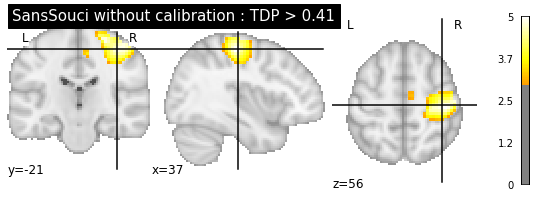

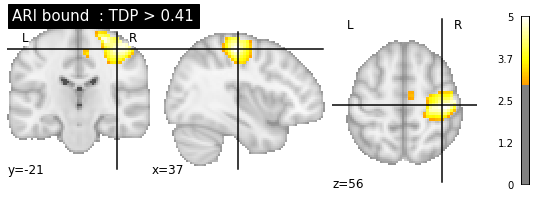

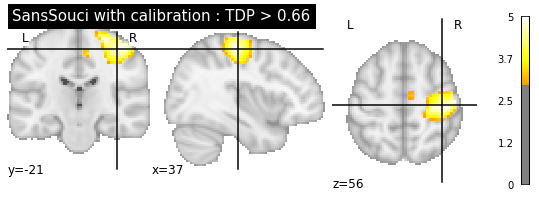

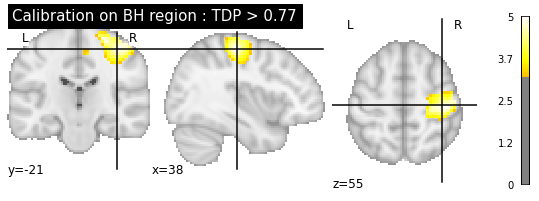

In [6]:
z_to_plot = z_map_
z_to_plot[labels != index_cluster] = 0
z_unmasked = nifti_masker.inverse_transform(z_to_plot)
# get unmasked region for plot
tdp_min_format = "{:.2f}".format(bound_sanssouci)
plotting.plot_stat_map(z_unmasked, title='SansSouci without \
calibration : TDP > %s' % (tdp_min_format), threshold=threshold)

print(bound_nilearn)
print(bound_sanssouci)
tdp_min_format = "{:.2f}".format(bound_nilearn)
plotting.plot_stat_map(z_unmasked, title='ARI bound \
 : TDP > %s' % (tdp_min_format), threshold=threshold)
# We get the correct bound
# Now let's see if the calibration is working

pval0 = sa.get_permuted_p_values_one_sample(fmri_input, B=100)

piv_stat = sa.get_pivotal_stats(pval0)
lambda_quant = np.quantile(piv_stat, alpha)
thr = sa.t_linear(lambda_quant, np.arange(1, p + 1), p)

res = sa.min_tp(cluster_p_values, thr)
bound_sanssouci = res / len(cluster_p_values)

tdp_min_format = "{:.2f}".format(bound_sanssouci)
plotting.plot_stat_map(z_unmasked, title='SansSouci with \
calibration : TDP > %s' % (tdp_min_format), threshold=threshold)

# Let's now compare our one-sample calibration to BH
BH_threshold = fdr_threshold(z_map_, alpha)

cluster_stats = stats_[z_map_ > BH_threshold]
cluster_p_values = p_values[z_map_ > BH_threshold]

res = sa.min_tp(cluster_p_values, thr)
bound_sanssouci = res / len(cluster_p_values)

z_to_plot = z_map_
z_to_plot[z_map_ <= BH_threshold] = 0
z_unmasked = nifti_masker.inverse_transform(z_to_plot)
tdp_min_format = "{:.2f}".format(bound_sanssouci)
plotting.plot_stat_map(z_unmasked, title='Calibration on BH region\
 : TDP > %s' % (tdp_min_format), threshold=BH_threshold)

In [84]:
import pyrft as pr
n = 16; p = 1;
categ = np.zeros(16); X = pr.group_design(categ); C = np.array(1)
field_data = pr.makefield(np.transpose(fmri_input))
tstats, _ = pr.contrast_tstats(field_data, X, C)
pvals = pr.tstat2pval(tstats.field, n-p, 0)

In [112]:
# Specify the number of bootstraps to use
B = 100

# Run the bootstrapped algorithm
minPperm, orig_pvalues, pivotal_stats, _ = pr.boot_contrasts(field_data, design = X, contrast_matrix = C, n_bootstraps = 100)

In [125]:
lambda_quant = np.quantile(pivotal_stats, alpha)
print(lambda_quant)

print(len(pivotal_stats))

0.0
100


In [111]:
print(field_data)

field: (47039, 16)
fieldsize: (47039, 16)
D: 1
masksize: (1, 47039)
fibersize: 16


In [113]:
alpha = 0.1

# Obtain the lambda calibration
lambda_quant = np.quantile(pivotal_stats, alpha)
print('Lambda Quantile:', lambda_quant)

# Calculate the number of voxels in the mask
m = np.sum(field_data.mask[:])

# Gives t_k^L(lambda) = lambda*k/m for k = 1, ..., m
thr = sa.t_linear(lambda_quant, np.arange(1,m+1), m)

res = sa.min_tp(cluster_p_values, thr)
bound_boot = res / len(cluster_p_values)
print(bound_boot)

Lambda Quantile: 0.0
0.0


In [104]:
m

47039

In [85]:
print(np.sort(np.transpose(pvals))[0:10])
print(np.sort(p_values)[0:10])

[[1.53004178e-08 2.33407460e-08 3.15693891e-08 ... 9.99940163e-01
  9.99958825e-01 9.99975388e-01]]
[1.53004081e-08 2.33407461e-08 3.15693972e-08 4.84700673e-08
 6.68535305e-08 7.54732484e-08 7.57267602e-08 7.74374159e-08
 7.97416473e-08 8.14819890e-08]


In [69]:
np.min(pvals)

1.5154871357836441e-07

In [64]:
print(pr.mvtstat(fmri_input[:, 0]))
print(tstats.field[0])

(-1.7847658376014262, -0.63863677, 1.4313065712250541)
[-1.78476586]


In [83]:
# Incorrect one sample pvalues?
from scipy.stats import t
n = 16
voxel_mean = fmri_input[:, 0].mean()
voxel_std_population = fmri_input[:, 0].std()*np.sqrt((n/(n-1)))
t_val = (voxel_mean/voxel_std_population)*np.sqrt(16)
p_val = 1 - t.cdf(t_val, n - 1)
print(p_val)

p_val = pr.tstat2pval(t_val, n-1, 0)
print(p_val)
print(p_values[0])

0.9527334725904406
0.09453305481911878
0.0945330344438295


In [60]:
voxel_std_population = fmri_input[:, 0].std()*(nsubj/(nsubj-1)


SyntaxError: unexpected EOF while parsing (<ipython-input-60-ec9b514fe228>, line 1)